In [50]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Button, Slider

import chugunov_indicator as chug

import pynucastro as pyna
import yt

In [51]:
from pynucastro.constants import constants
from pynucastro.screening.screen import f0

In [52]:
q = 1/3

With $q = 1/3$, we define
$$
    A =: (T \rho^3)^q, \quad B := (\rho/T^3)^q.
$$
in other words, we have a rotation and scaling
$$
    a = q(3d + t), \quad b = q (d - 3 t).
$$
where $A = 10^a$ and so on. This gives
$$
    t = \frac{1}{10q} (a - 3b), \quad d = \frac{1}{10q} (3a + b),
$$
or in other words,
$$
    T = (A/B^3)^{1/10q}, \quad D = (B A^3)^{1/10q}.
$$

In [53]:
def TD_to_AB(T: float, D: float) -> tuple[float, float]:
    return (T*D**3)**q, (D/T**3)**q

def AB_to_TD(A: float, B: float) -> tuple[float, float]:
    return (A/B**3)**(3/10), (B*A**3)**(3/10)

In [54]:
A_ = np.logspace(-5*q, 33.35*q, num=200)
B_ = np.logspace(-32.05*q, -13*q, num=200)
A, B = np.meshgrid(A_, B_)

In [55]:
T, D = AB_to_TD(A, B)

In [56]:
starting_kwargs = {
    "abar": 4.028776983649795,
    "zbar": 2,
    "z2bar": 4.12949645671095,
    "z1": 2,
    "z2": 6
}

fixed_kwargs = {
    "a1": 4,
    "a2": 12
}

In [57]:
F = chug.chugunov_2009(T=T, D=D, **starting_kwargs, **fixed_kwargs)

C:\Users\Sam\AppData\Local\Temp\ipykernel_16864\386316134.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig1, ax1 = plt.subplots()


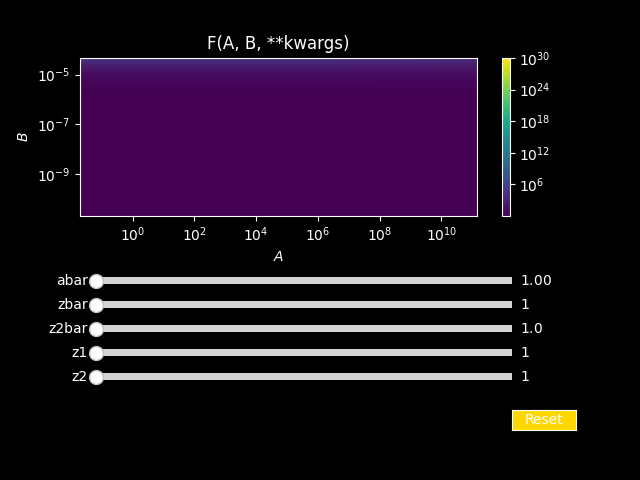

In [58]:
%matplotlib widget

fig1, ax1 = plt.subplots()
fig1.subplots_adjust(bottom=0.55)

params1 = {
    "abar": (1, 52.43965444432472),
    "zbar": (1, 100),
    "z2bar": (1, 713.3104742534674),
    "z1": (1, 20),
    "z2": (1, 20)
}

graph1 = chug.SliderGraph(fig1, ax1, params1)
graph1.fig.subplots_adjust(bottom=0.55)
graph1.ax.set_title("Screening Factors Fit")

graph1.ax.set_title("F(A, B, **kwargs)")

graph1.ax.set_xlabel("$A$")
graph1.ax.set_ylabel("$B$")

graph1.ax.set_xscale("log")
graph1.ax.set_yscale("log")

# Create initial plot
cb = graph1.ax.pcolormesh(A, B, F, norm="log")
cbar = graph1.fig.colorbar(cb)

# Create function to be called when slider value is changed
def update1(val=None) -> None:
    F_new = chug.chugunov_2009(T, D, **graph1.slider_vals(), **fixed_kwargs)
    cb.set_array(F_new)

graph1.update_func(update1)
graph1.update()

# Show graph
#fig1.show()

As expected, $A$ only matters at very high values of $F$. This effect is more pronounced when $\bar{Z}$ is high.

In [59]:
dF = np.gradient(F, A_, B_)

In [68]:
dF[0].min(), np.median(dF[0]), dF[0].max()

(3.7400706818769335e-08, 6.619078789051719e-07, 6.563754009488593e+19)

In [61]:
A__ = 10**4
B__ = np.logspace(-32.05*q, -13*q, num=1000)

T__, D__ = AB_to_TD(A__, B__)

In [62]:
F__ = chug.chugunov_2009(T=T__, D=D__, **starting_kwargs, **fixed_kwargs)

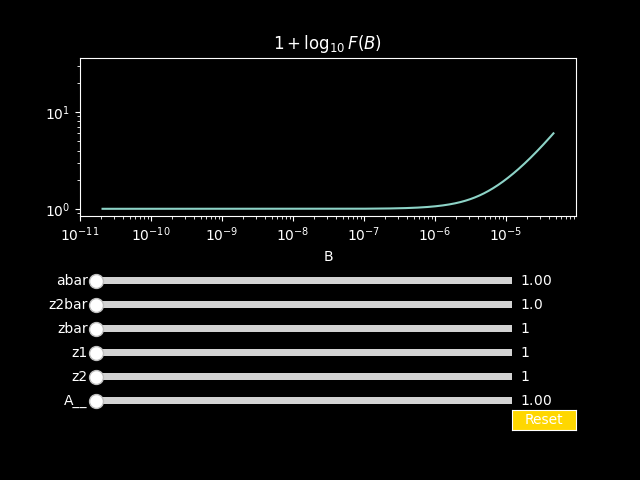

In [63]:
%matplotlib widget

fig2, ax2 = plt.subplots()

params2 = {
    "abar": (1, 52.43965444432472),
    "z2bar": (1, 713.3104742534674),
    "zbar": (1, 100),
    "z1": (1, 20),
    "z2": (1, 20),
    "A__": (1, 33.35*q)
}

graph2 = chug.SliderGraph(fig2, ax2, params2)
graph2.fig.subplots_adjust(bottom=0.55)


graph2.ax.set_title("$1 + \\log_{10} F(B)$")

graph2.ax.set_xlabel("B")
graph2.ax.set_xscale("log")
graph2.ax.set_yscale("log")

# Create initial plot
new_line, = graph2.ax.plot(B__, 1 +np.log10(F__))

# Create function to be called when slider value is changed
def update2(val=None) -> None:
    kwargs_new = graph2.slider_vals()
    A__new = 10**kwargs_new["A__"]
    del kwargs_new["A__"]

    T__new, D__new = AB_to_TD(A__new, B__)

    F__new = chug.chugunov_2009(T__new, D__new, **kwargs_new, **fixed_kwargs)

    new_line.set_ydata(1 + np.log10(F__new))


graph2.update_func(update2)
graph2.update()

# Show graph
#fig2.show()

As before, $A$ only affects $F$ at high $B$.

From here, notice that
$$
    \Gamma_e \propto \sqrt[3]{\frac{\rho \bar{Z}}{\bar{A}}} \frac{1}{T} = \gamma_e \sqrt[3]{\frac{\bar{Z}}{\bar{A}}} B,
$$
where the proportionality constant $\gamma_e$ is the remaining factors in equation 6 of the original paper.

In [64]:
def F_fit(
        T: float, D: float,
        abar: float, zbar: float, z2bar: float,
        z1: int, z2: int,
        a1: int, a2: int,
    ) -> float:
    """Calculates screening factors based on :cite:t:`chugunov:2009` in `NumPy`-friendly form.

    :param PlasmaState state:     the precomputed plasma state factors
    :param ScreenFactors scn_fac: the precomputed ion pair factors
    :returns: screening correction factor
    """

    # Precomputed Values
    mbar = abar * constants.m_u
    ntot = D / mbar

    # Electron number density
    # zbar * ntot works out to sum(z[i] * n[i]), after cancelling terms
    n_e = zbar * ntot

    # temperature-independent part of Gamma_e, from Chugunov 2009 eq. 6
    gamma_e_fac = constants.q_e ** 2 / constants.k * np.cbrt(4 * np.pi / 3) * np.cbrt(n_e)

    aznut = np.cbrt(z1 ** 2 * z2 ** 2 * a1 * a2 / (a1 + a2))
    ztilde = 0.5 * (np.cbrt(z1) + np.cbrt(z2))

    # z1z2 and zcomp
    z1z2 = z1 * z2
    zcomp = z1 + z2

    # Gamma_e from eq. 6
    Gamma_e = gamma_e_fac / T

    # Coulomb coupling parameters for ions and compound nucleus, eqs. 7 & 9
    Gamma_1 = Gamma_e * z1 ** (5 / 3)
    Gamma_2 = Gamma_e * z2 ** (5 / 3)
    Gamma_comp = Gamma_e * zcomp ** (5 / 3)

    Gamma_12 = Gamma_e * z1z2 / ztilde

    # Coulomb barrier penetrability, eq. 10
    tau_factor = np.cbrt(27 / 2 * (np.pi * constants.q_e ** 2 / constants.hbar) ** 2 * constants.m_u / constants.k)
    tau_12 = tau_factor * aznut / np.cbrt(T)

    # eq. 12
    zeta = 3 * Gamma_12 / tau_12

    # additional fit parameters, eq. 25
    y_12 = 4 * z1z2 / zcomp ** 2
    c1 = 0.013 * y_12 ** 2
    c2 = 0.406 * y_12 ** 0.14
    c3 = 0.062 * y_12 ** 0.19 + 1.8 / Gamma_12

    poly = 1 + zeta*(c1 + zeta*(c2 + c3*zeta))
    t_12 = np.cbrt(poly)

    # strong screening enhancement factor, eq. 23, replacing tau_ij with t_ij
    # Using Gamma/tau_ij gives extremely low values, while Gamma/t_ij gives
    # values similar to those from Chugunov 2007.
    term1 = f0(Gamma_1 / t_12)
    term2 = f0(Gamma_2 / t_12)
    term3 = f0(Gamma_comp / t_12)
    h_fit = term1 + term2 - term3

    # weak screening correction term, eq. A3
    corr_C = (
        3 * z1z2 * np.sqrt(z2bar / zbar) /
        (zcomp ** 2.5 - z1 ** 2.5 - z2 ** 2.5)
    )

    # corrected enhancement factor, eq. A4
    Gamma_12_2 = Gamma_12 ** 2
    numer = corr_C + Gamma_12_2
    denom = 1 + Gamma_12_2

    return h_fit, numer/denom

In [65]:
H__, corr__ = F_fit(T=T__, D=D__, **starting_kwargs, **fixed_kwargs)

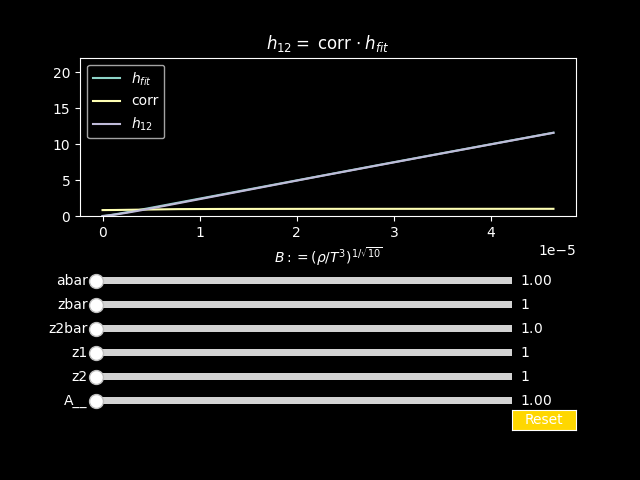

In [66]:
%matplotlib widget

fig3, ax3 = plt.subplots()

params3 = {
    "abar": (1, 52.43965444432472),
    "zbar": (1, 100),
    "z2bar": (1, 713.3104742534674),
    "z1": (1, 20),
    "z2": (1, 20),
    "A__": (1, 33.35*q)
}

graph3 = chug.SliderGraph(fig3, ax3, params3)
graph3.fig.subplots_adjust(bottom=0.55)


graph3.ax.set_title("$h_{12} =$ corr $\\cdot \\: h_{fit}$")

graph3.ax.set_xlabel("$B := (\\rho/T^3)^{1/\\sqrt{10}}$")
graph3.ax.set_ylim(0, 22)
#graph3.ax.set_xscale("log")
#graph3.ax.set_yscale("log")

# Create initial plot
H, = graph3.ax.plot(B__, H__, label="$h_{fit}$")
corr, = graph3.ax.plot(B__, corr__, label="corr")
scor, = graph3.ax.plot(B__, H__*corr__, label="$h_{12}$")

graph3.ax.legend()

# Create function to be called when slider value is changed
def update3(val=None) -> None:
    kwargs_new = graph3.slider_vals()
    A__new = 10**kwargs_new["A__"]
    del kwargs_new["A__"]

    T__new, D__new = AB_to_TD(A__new, B__)

    H__new, corr__new = F_fit(T__new, D__new, **kwargs_new, **fixed_kwargs)

    H.set_ydata(H__new)
    corr.set_ydata(corr__new)
    scor.set_ydata(H__new*corr__new)


graph3.update_func(update3)
graph3.update()

# Show graph
#fig3.show()